# Initialization

## Imports

In [ ]:
import numpy as np
import pandas as pd
import ast
from scipy.sparse import dok_matrix
import torch
import random
import torch.nn.functional as F
from torch import nn
import math
import torchaudio as T
import os
from torch.multiprocessing import Pool
from typing import List, Callable
import time
import datetime

## Hyperparameters

In [ ]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

epochs = 1
batch_size  = 64
learning_rate = 0.001
num_epochs = 10
num_threads = 2
lr = 0.001

test_size = 0.2

In [ ]:
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Loading

In [ ]:
from google.colab import drive
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ./dataset
!unzip -q /content/drive/MyDrive/datasets/ML/birdclef-2023.zip -d ./dataset

In [ ]:
class SoundDataset(Dataset):
    def __init__(self, root_dir):
        self.file_list = []
        self.label_list = []
        self.labels = []
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            self.labels.append(label)
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                self.file_list.append(file_path)
                self.label_list.append(label)
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        waveform, sample_rate = T.load(self.file_list[idx])
        label = self.labels.index(self.label_list[idx])
        target_length = 32000 * 8 # 32kHz * 8 seconds
        if waveform.shape[1] < target_length:
          waveform = F.pad(waveform, (0, target_length - waveform.shape[1]), mode='constant', value=0)
        else:
          waveform = waveform[:,:target_length]
        return waveform, label

In [ ]:
# Define the dataset and data loader
dataset = SoundDataset('/content/dataset/train_audio')
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()

g.manual_seed(0)

In [ ]:
# Assuming `my_dataset` is your dataset object
dataset_size = len(dataset)
train_size = int(TRAIN_SIZE * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator=g
)

In [ ]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_threads,
    worker_init_fn=seed_worker,
    generator=g,
)
valid_dl = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_threads,
    worker_init_fn=seed_worker,
    generator=g,
)

In [ ]:
ab = next(iter(train_dl))

In [ ]:
import torchaudio.transforms as TT
from torchvision.transforms import transforms
resample = TT.Resample(orig_freq=32000, new_freq=16000)
m_spec = nn.Sequential(
    TT.MelSpectrogram(sample_rate=16000, n_fft=1100, n_mels=120),
    TT.AmplitudeToDB(),
)
aug = nn.Sequential(
    TT.TimeStretch(0.8, fixed_rate=True),
    TT.FrequencyMasking(freq_mask_param=30),
    TT.TimeMasking(time_mask_param=80),
)
resize = transforms.Resize((512, 512))

In [ ]:
zxc = resample(ab[0])
zxc = m_spec(zxc)
print(zxc.shape)
# zxc = aug(zxc)
# zxc = resize(zxc)
zxc.shape

torch.Size([64, 1, 120, 233])


torch.Size([64, 1, 120, 233])

In [ ]:
zxc[0][0].shape

torch.Size([120, 233])

In [ ]:
import matplotlib.pyplot as plt

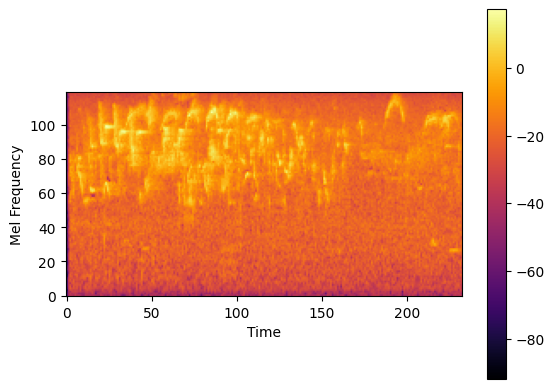

In [ ]:
# Convert to numpy array for plotting
mel_spec_db = zxc[0][0].numpy()

# Plot mel spectrogram
plt.imshow(mel_spec_db, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar()
plt.show()

In [ ]:
def forward_tensor(x: torch.Tensor, dim=2) -> torch.Tensor:
  min = x.min(dim=dim).values
  max = x.max(dim=dim).values
  norm = (x - min) / (max - min)
  norm = torch.where(torch.isnan(norm), 0, norm)
  return norm

In [ ]:
forward_tensor(zxc, dim=0).shape

torch.Size([64, 1, 120, 233])

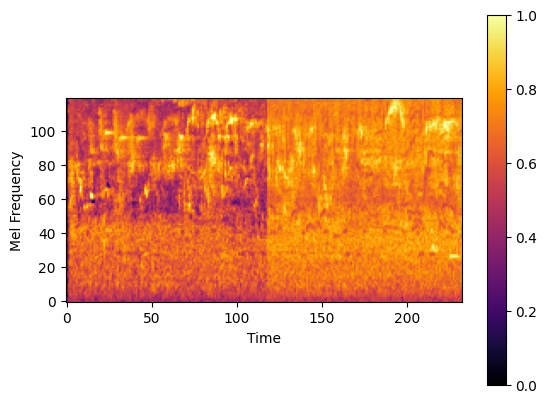

In [ ]:
# Convert to numpy array for plotting
mel_spec_db = forward_tensor(zxc, dim=0)[0][0].detach().numpy()

# Plot mel spectrogram
plt.imshow(mel_spec_db, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar()
plt.show()

In [ ]:
mfcc = TT.MFCC()

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
zxc1 = resample(ab[0])
# zxc1 = m_spec(zxc)
zxc1 = mfcc(zxc1)
print(zxc1.shape)
# zxc1 = aug(zxc)
# zxc1 = resize(zxc)
zxc1.shape

torch.Size([64, 1, 40, 641])


torch.Size([64, 1, 40, 641])

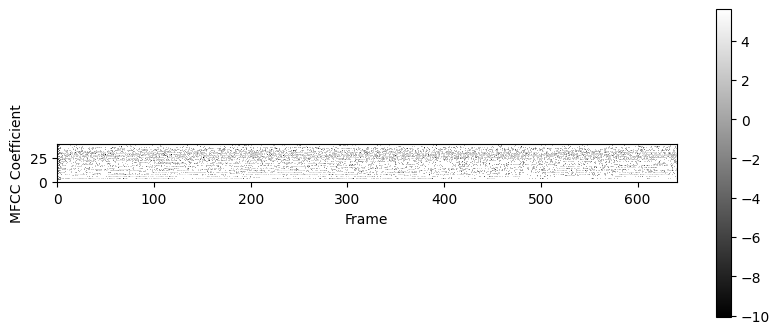

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(zxc1.log2()[0][0].detach().numpy(), cmap='gray', interpolation='nearest', origin='lower')
plt.xlabel('Frame')
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.show()

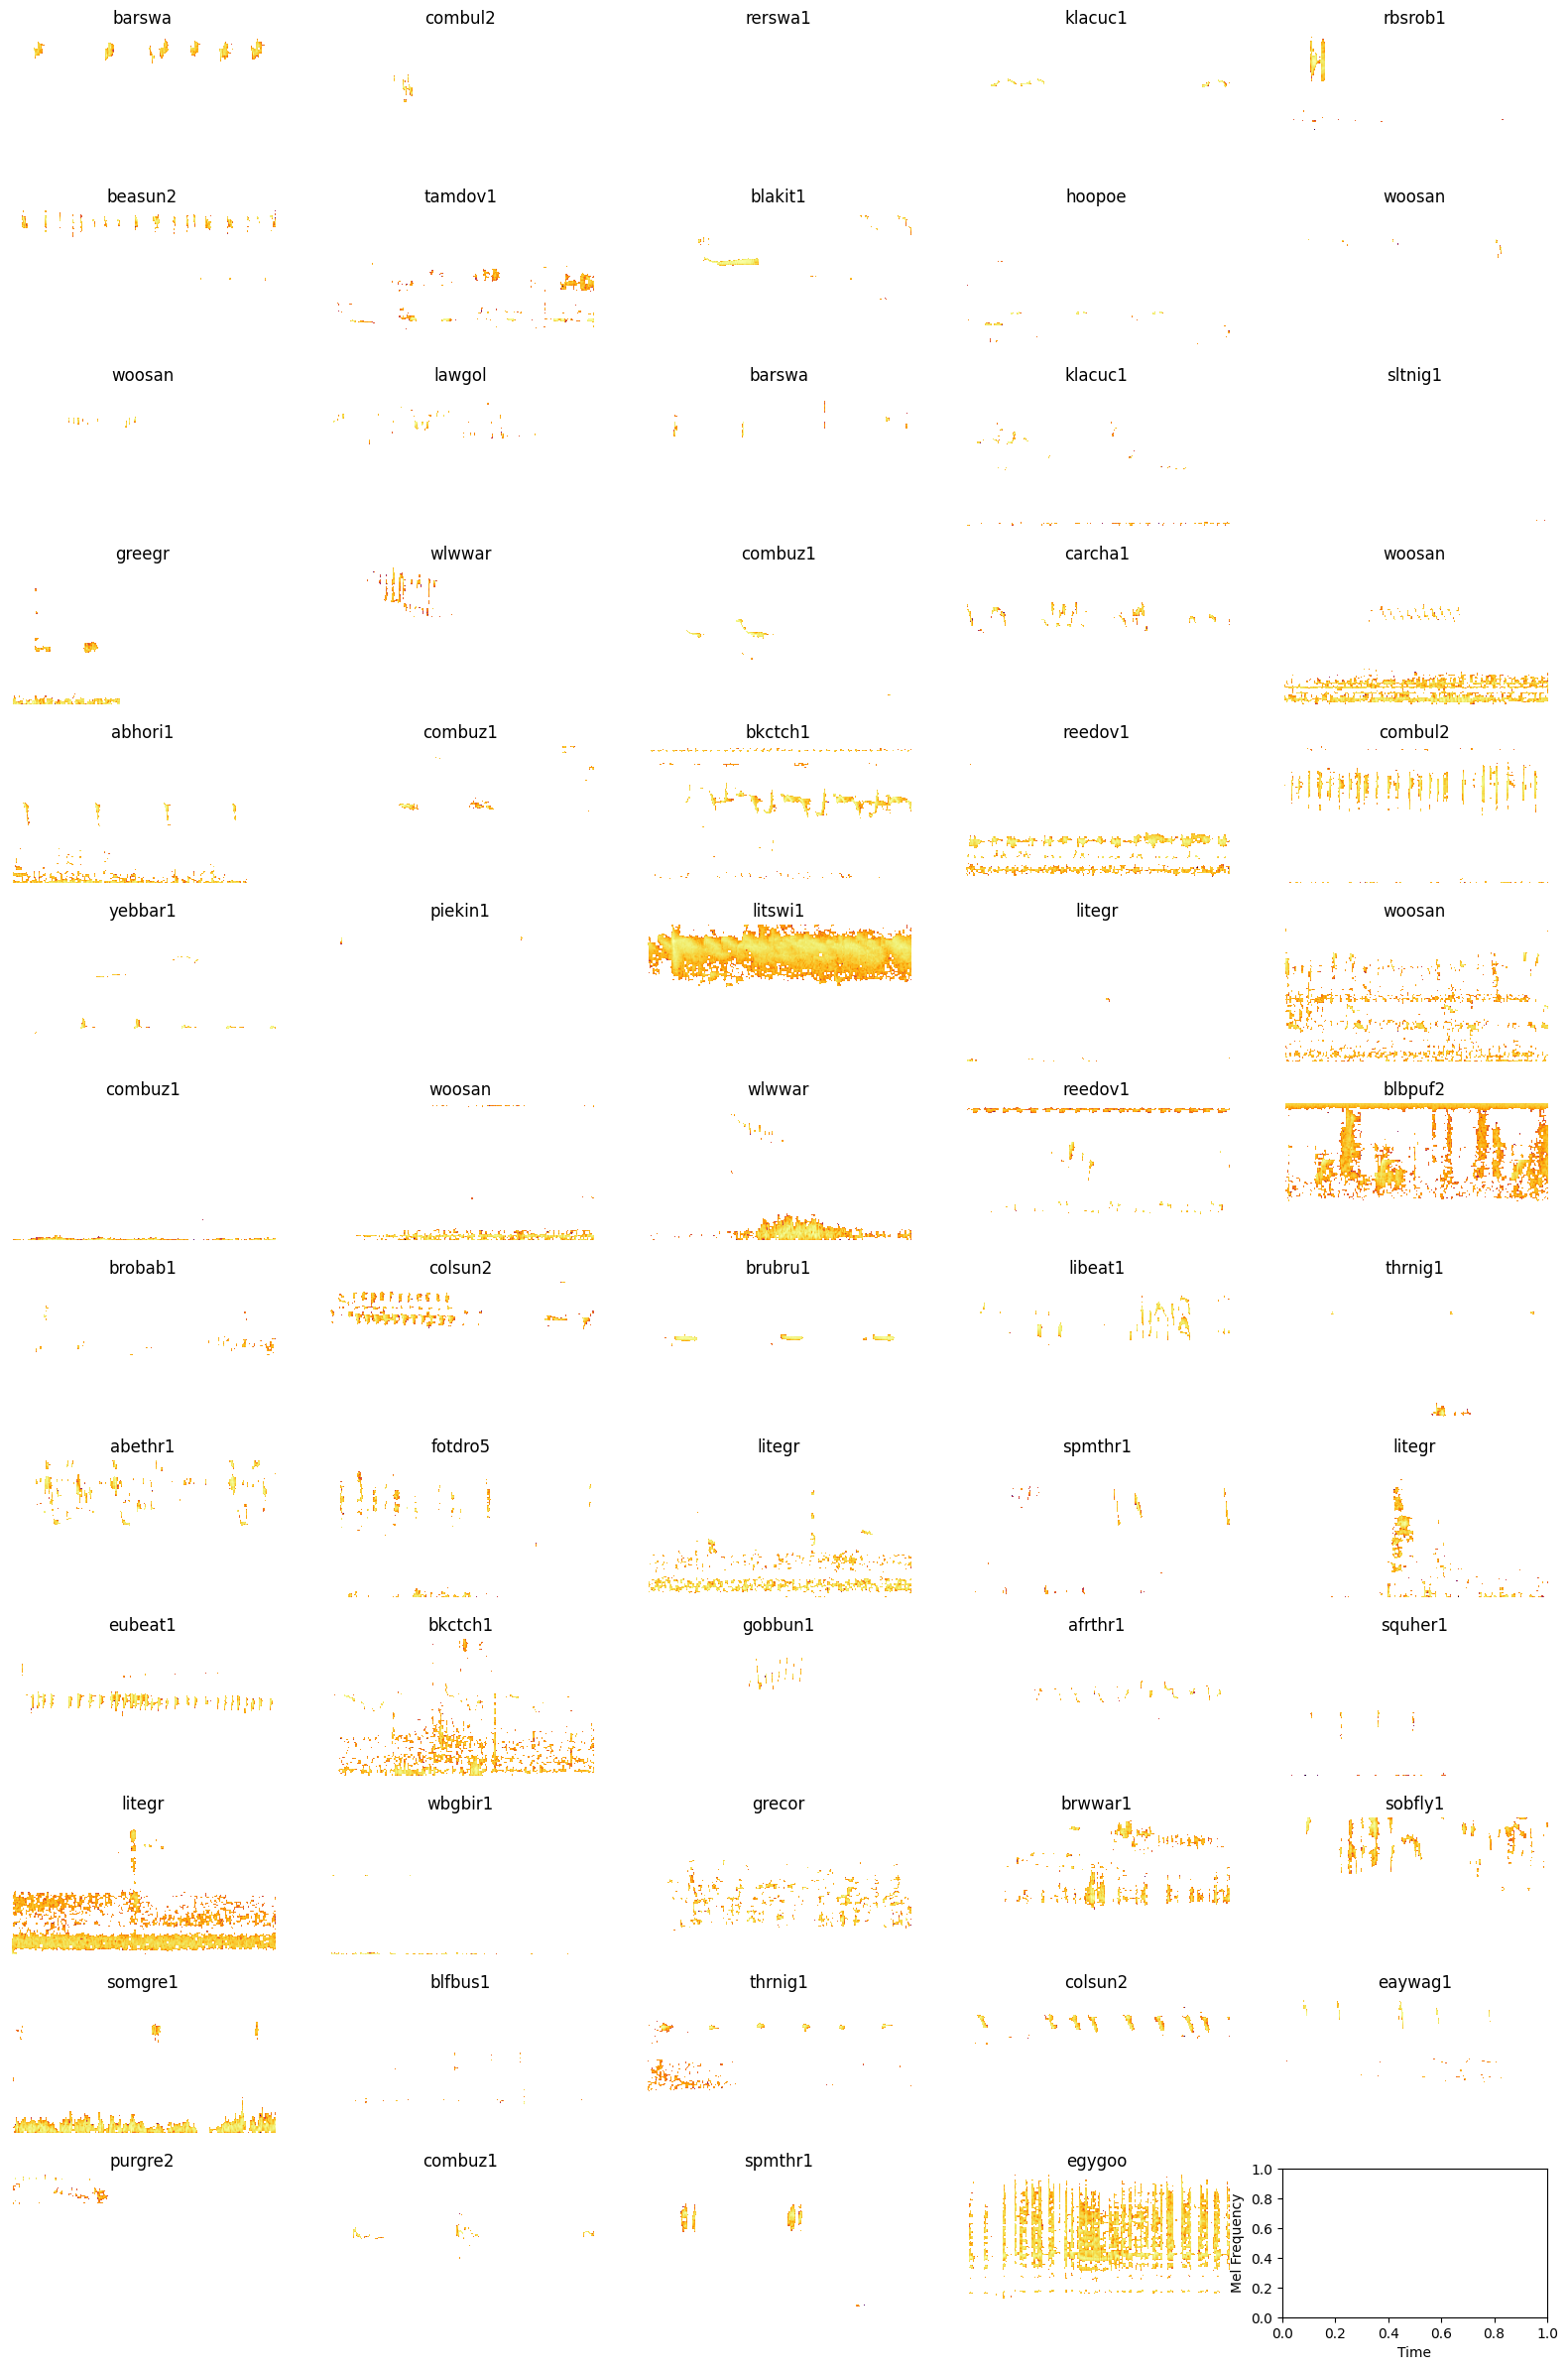

In [ ]:
# Convert to numpy array for plotting
# mel_spec_db = forward_tensor(zxc, dim=0)[0][0]
n_cols = 5
n_rows = (zxc.shape[0] - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))

log_mel = torch.log(zxc + 1e-9)

axs = axs.flatten() if n_rows == 1 else axs
for i in range(n_rows):
  add = i * n_cols
  for j in range(n_cols):
    if add + j >= zxc.shape[0]: break
    # axs[i][j].imshow(zxc[add + j][0], cmap='inferno', origin='lower')
    axs[i][j].imshow(log_mel[add + j][0], cmap='inferno', origin='lower')
    axs[i][j].set_axis_off()
    axs[i][j].set_title(dataset.labels[ab[1][add + j]])

# Plot mel spectrogram
# plt.imshow(log_mel_spec, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
# plt.colorbar()
plt.show()

# DL Models

# DL

## Imports

In [ ]:
from torchvision import transforms, models
from torchsummary import summary
import torchaudio.transforms as TT
import pywt
from torch.optim import SGD

## Module Declaration

### Transforms

In [ ]:
class ToTensor1D(nn.Module):
  def __init__(self, dim=0):
    super(ToTensor1D, self).__init__()
    self.dim = dim

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    min = x.min(dim=self.dim).values
    max = x.max(dim=self.dim).values
    norm = (x - min) / (max - min)
    norm = torch.where(torch.isnan(norm), 0, norm)
    return norm

In [ ]:
class WaveletTransform(nn.Module):
  def __init__(self, wavelet: pywt.Wavelet, length_lim=128_000):
    super(WaveletTransform, self).__init__()
    self.wavelet = wavelet
    self.length_lim = length_lim

  def concat_dwt_flat(self, X: torch.Tensor, hl_features: torch.Tensor):
    return torch.cat((X, hl_features), dim=1).to(device)

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    inp = X.cpu().numpy()
    out = None
    for item in inp:
      wh, wl = pywt.dwt(item[0], pywt.Wavelet('sym4'))
      ca = torch.cat((torch.from_numpy(wh), torch.from_numpy(wl)))
      max_len = self.length_lim if len(ca) > self.length_lim else len(ca)
      ca = ca[:max_len]
      if out is None:
        out = ca.unsqueeze(0)
      else:
        out = torch.cat([out, ca.unsqueeze(0)], dim=0)
    # return out.view(len(inp), 1, max_len).to(device) # no need to put on view because of flatten
    # shape: batch_size x length_lim
    return out.to(device)

In [ ]:
class AudioTransforms(nn.Module):
  def __init__(
      self, 
      input_freq=32000,
      resample_freq=16000,
      stretch_factor=0.8,
      resize=256
  ):
    super(AudioTransforms, self).__init__()

    self.resample = TT.Resample(orig_freq=input_freq, new_freq=resample_freq)
    # mel spectogram automatically converts to 0-1, but DB converts -100 to n_mels
    self.m_spec = nn.Sequential(
        # Size after Mel Spectogram: (1 channel, 128, 640)    
        # TT.MelSpectrogram(sample_rate=32000, n_fft=801),
        # Size after Mel Spectogram: (1 channel, 256, 257)
        # TT.MelSpectrogram(sample_rate=resample_freq, n_fft=1000, n_mels=256),
        # TT.AmplitudeToDB(),
        TT.MFCC(sample_rate=resample_freq)
    )
    self.aug = nn.Sequential(
        TT.TimeStretch(0.8, fixed_rate=True),
        TT.FrequencyMasking(freq_mask_param=30),
        TT.TimeMasking(time_mask_param=80),
    )
    self.transforms = nn.Sequential(
        transforms.Resize((resize, resize)),
        # nn.BatchNorm2d(1),
    )
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    val = self.resample(x)
    # val = self.m_spec(val)
    val = self.m_spec(val).log2()
    val = self.aug(val)
    val = self.transforms(val)
    # val = torch.log(val + 1e-9)
    return val

### Convolutional Layers

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, **kwargs):
    super(ConvBlock, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU()
    )

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.cnn(X)

In [ ]:
class MobileConv(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, stride=1, padding=0):
    super(MobileConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(
            in_channels, in_channels, 
            kernel_size=3, stride=stride, 
            padding=padding, groups=in_channels
        ),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    val = self.conv(x)
    return val

### Models

In [ ]:
class YansNet2(nn.Module):
  def __init__(
    self,
    num_classes: int,
    include_wavelet=False,
    input_freq=32000,
    resample_freq=16000,
    stretch_factor=0.8,
    resize=256,
    max_wavelength=100_000
  ):
    super(YansNet2, self).__init__()

    self.include_wavelet = include_wavelet

    self.transforms = nn.Sequential(
      AudioTransforms(
        input_freq = input_freq, 
        resample_freq = resample_freq,
        stretch_factor = stretch_factor,
        resize = resize
      ),
      ToTensor1D(dim=0)
    )

    if include_wavelet:
      self.wavelet = WaveletTransform(pywt.Wavelet('sym4'), max_wavelength)

    self.conv = nn.Sequential(
        # init conv
        ConvBlock(
            in_channels=1, out_channels=32, 
            kernel_size=(3, 3), 
            padding=1, stride=2
        ),
        MobileConv(
            in_channels=32, out_channels=64,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=64, out_channels=128,
            padding=1, stride=2
        ),
        MobileConv(
            in_channels=128, out_channels=128,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=128, out_channels=256,
            padding=1, stride=2
        ),
        MobileConv(
            in_channels=256, out_channels=256,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=256, out_channels=512,
            padding=1, stride=2
        ),
        # 5-block
        MobileConv(
            in_channels=512, out_channels=512,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=512, out_channels=512,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=512, out_channels=512,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=512, out_channels=512,
            padding=1, stride=1
        ),
        MobileConv(
            in_channels=512, out_channels=512,
            padding=1, stride=1
        ),

        MobileConv(
            in_channels=512, out_channels=1024,
            padding=1, stride=2
        ),
        MobileConv(
            in_channels=1024, out_channels=1024,
            padding=1, stride=2
        ),

        # block 5
        nn.AvgPool2d(int(resize / (2 ** 6))) # results to n x 1024 x 1 x 1
    )

    class_len = 1024 + max_wavelength if include_wavelet else 1024

    # self.flatten = nn.Flatten() #  n x 1024 x 1 x 1
    self.classifier = nn.Sequential(
        nn.Linear(class_len, num_classes)
    )


  def forward(self, X: torch.Tensor) -> torch.Tensor:
    val = self.transforms(X)
    val = self.conv(val)
    val = val.view(val.shape[0], -1)

    if self.include_wavelet: 
      wavelets = ToTensor1D(dim=0)(self.wavelet(X))
      val = self.wavelet.concat_dwt_flat(val, wavelets)
    
    logits = self.classifier(val)
    probas = torch.softmax(val, dim=1)
    return logits, probas

In [ ]:
# best result for valid using mobilenetv2 = 63.46154022216797
class YansNet(nn.Module):
  def __init__(
    self,
    num_classes: int,
    include_wavelet=False,
    input_freq=32000,
    resample_freq=16000,
    stretch_factor=0.8,
    resize=256,
    max_wavelength=100_000
  ):
    super(YansNet, self).__init__()

    self.include_wavelet = include_wavelet

    self.transforms = nn.Sequential(
      AudioTransforms(
        input_freq = input_freq, 
        resample_freq = resample_freq,
        stretch_factor = stretch_factor,
        resize = resize
      ),
      ToTensor1D(dim=0)
    )

    if include_wavelet:
      self.wavelet = WaveletTransform(pywt.Wavelet('sym4'), max_wavelength)
    
    self.init_cnn = ConvBlock(1, 3, kernel_size=3, padding=1)


    model = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
    ).to(device)

    for param in model.parameters():
      param.requires_grad = False

    first_linear_len = 576 + max_wavelength if include_wavelet else 576

    model.classifier = nn.Sequential(
        nn.Linear(first_linear_len, 1024, bias=True),
        nn.Hardswish(),
        nn.Dropout(0.2, True),
        nn.Linear(in_features=1024, out_features=num_classes, bias=True)
    )

    self.model = model

    # # TODO: MobileNet archi
    # # self.cnn1 = ConvBlock(1, 64, kernel_size=(3, 3), padding=(1,1)) 
    # self.cnn1 = nn.Sequential(
    #     ConvBlock(1, 64, kernel_size=3, padding=1), # 512 x 512 x 64
    #     ConvBlock(64, 64, kernel_size=3, padding=1), # 512 x 512 x 64
    #     ConvBlock(64, 64, kernel_size=3, padding=1), # 512 x 512 x 64
    #     nn.MaxPool2d(2) # 256 x 256 x 64
    # )
    # # self.cnn2 = ConvBlock(64, 128, kernel_size=(3, 3), padding=(1,1)) 
    # self.cnn2 = nn.Sequential(
    #     ConvBlock(64, 128, kernel_size=3, padding=1), # 256 x 256 x 128
    #     ConvBlock(128, 128, kernel_size=3, padding=1), # 256 x 256 x 128
    #     ConvBlock(128, 128, kernel_size=3, padding=1), # 256 x 256 x 128
    #     nn.MaxPool2d(2) # 128 x 128 x 128
    # )
    # # self.cnn3 = ConvBlock(128, 256, kernel_size=(3, 3), padding=(1,1)) 
    # self.cnn3 = nn.Sequential(
    #     ConvBlock(128, 256, kernel_size=3, padding=1), # 128 x 128 x 256
    #     ConvBlock(256, 256, kernel_size=3, padding=1), # 128 x 128 x 256
    #     ConvBlock(256, 256, kernel_size=3, padding=1), # 128 x 128 x 256
    #     nn.MaxPool2d(2) # 64 x 64 x 256
    # )
    # # self.cnn4 = ConvBlock(256, 256, kernel_size=(1, 1)) 
    # self.cnn4 = nn.Sequential(
    #     ConvBlock(256, 512, kernel_size=3, padding=1), # 64 x 64 x 512
    #     ConvBlock(512, 512, kernel_size=3, padding=1), # 64 x 64 x 512
    #     ConvBlock(512, 512, kernel_size=3, padding=1), # 64 x 64 x 512
    #     nn.MaxPool2d(2) # 32 x 32 x 512
    # )

    # self.cnn = nn.ModuleList([
    #     self.cnn1,
    #     self.cnn2,
    #     self.cnn3,
    #     self.cnn4
    #     # self.cnn1, # 64 x 64 x 64
    #     # nn.Dropout2d(p=0.5),
    #     # nn.MaxPool2d(2), # 32 x 32 x 64
    #     # self.cnn2, # 32 x 32 x 128
    #     # nn.Dropout2d(p=0.5),
    #     # nn.MaxPool2d(2), # 16 x 16 x 128
    #     # self.cnn3, # 16 x 16 x 256
    #     # nn.Dropout2d(p=0.5),
    #     # nn.MaxPool2d(2), # 8 x 8 x 256
    #     # self.cnn4, # 8 x 8 x 512
    #     # nn.Dropout2d(p=0.5),
    #     # nn.MaxPool2d(2) # 4 x 4 x 512
    # ])

    # too many params
    # self.classifier = nn.Sequential(
    #     nn.Flatten(), # 32 * 32 * 512
    #     # something
    #     nn.Linear(32 * 32 * 512, 32 * 32 * 512),
    #     nn.ReLU(),
    #     nn.Linear(32 * 32 * 512, 10 * 10 * 64),
    #     nn.ReLU(),
    #     nn.Linear(10 * 10 * 64, num_classes)
    # )

  def forward(self, X: torch.Tensor) -> torch.Tensor: 
    # wavelets = torch.stack([pywt.dwt(tensor.numpy()) for tensor in X])
    val = self.transforms(X)
    val = self.init_cnn(val)

    # val = self.norm(val)
    # val = torch.cat((val, wavelets))
    # for cnn in self.cnn:
    #   val = cnn(val)
    # logits = self.classifier(val)
    logits = self.model(val)
    # val = val.view(val.shape[0], -1)
    # if self.include_wavelet: 
    #   wavelets = ToTensor1D(dim=0)(self.wavelet(X))
    #   val = self.wavelet.concat_dwt_flat(val, wavelets)
    probas = torch.softmax(logits, 1)
    return logits, probas

## Instantiation

In [ ]:
model = YansNet(num_classes=len(dataset.labels)).to(device)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (501) may be set too low.
  warnings.warn(


In [ ]:
model = YansNet2(num_classes=len(dataset.labels), include_wavelet=False, resize=512).to(device)

## Validation Declaration

In [ ]:
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

## Training

### Imports

In [ ]:
from torch.utils.tensorboard import SummaryWriter

### Function Declarations

In [ ]:
def train_one_epoch(epoch_index: int, writer) -> float:
    epoch_cost = []

    train_len = len(train_dl)
    
    for i, data in enumerate(train_dl):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = torch.tensor(labels, device=device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        logits, outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(logits, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        cost = loss.item()

        tb_x = epoch_index * train_len + i + 1
        writer.add_scalar('Loss/train', cost, tb_x)

        if not i % 20:
          print('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f' 
                %(epoch_index + 1, epochs, i, 
                  len(train_dl), cost))

        # Clearing memory
        del inputs, labels, logits, outputs, loss    

In [ ]:
def validate(dataloader: DataLoader) -> tuple[float]:
  correct_pred = 0.0
  running_vloss = 0.0
  num_examples = 0
  i = 0

  loader_len = len(dataloader)

  for i, vdata in enumerate(dataloader):
    vinputs, vlabels = vdata
    vinputs = vinputs.to(device)
    vlabels = torch.tensor(vlabels, device=device)

    vlogits, voutputs = model(vinputs)
    vloss = F.cross_entropy(vlogits, vlabels)
    running_vloss += vloss.item()

    _, predicted_labels = torch.max(voutputs, 1)
    correct_pred += torch.sum((predicted_labels == vlabels))
    num_examples += vlabels.size(0)

    del vinputs, vlabels, voutputs, vloss

  avg_vloss = running_vloss / (i + 1)

  return correct_pred / num_examples * 100, avg_vloss

In [ ]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/birdclef_{}'.format(timestamp))

### Training Procedure

In [ ]:
epoch_number = 0
best_vloss = 1_000_000.

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    # validating
    acc, avg_loss = validate(train_dl)
    vacc, avg_vloss = validate(valid_dl)

    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACC train {} valid {}'.format(acc, vacc))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training': acc, 'Validation': vacc },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


<ipython-input-31-ad70e81e264b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 00001/00001 | Batch 00000/00186 | Cost: 5.5768
Epoch: 00001/00001 | Batch 00020/00186 | Cost: 5.5779
Epoch: 00001/00001 | Batch 00040/00186 | Cost: 5.5696
Epoch: 00001/00001 | Batch 00060/00186 | Cost: 5.5709
Epoch: 00001/00001 | Batch 00080/00186 | Cost: 5.5666
Epoch: 00001/00001 | Batch 00100/00186 | Cost: 5.5649
Epoch: 00001/00001 | Batch 00120/00186 | Cost: 5.5726
Epoch: 00001/00001 | Batch 00140/00186 | Cost: 5.5629
Epoch: 00001/00001 | Batch 00160/00186 | Cost: 5.5606
Epoch: 00001/00001 | Batch 00180/00186 | Cost: 5.5617


<ipython-input-32-be774e4c1772>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vlabels = torch.tensor(vlabels, device=device)


OutOfMemoryError: ignored

In [ ]:
# epoch_number = 0
# best_vloss = 1_000_000.

# for epoch in range(epochs):
#     print('EPOCH {}:'.format(epoch_number + 1))

#     # Make sure gradient tracking is on, and do a pass over the data
#     model.train(True)
#     acc, avg_loss = train_one_epoch(epoch_number, writer)

#     # We don't need gradients on to do reporting
#     model.train(False)

#     # validating
#     vacc, avg_vloss = validate()

#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
#     print('ACC train {} valid {}'.format(acc, vacc))

#     # Log the running loss averaged per batch
#     # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.add_scalars('Training vs. Validation Accuracy',
#                     { 'Training': acc, 'Validation': vacc },
#                     epoch_number + 1)
#     writer.flush()

#     # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

#     epoch_number += 1

EPOCH 1:


Training batches:   0%|          | 0/212 [00:00<?, ?it/s]<ipython-input-21-005e2b3d1fd2>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to we

batch 22 loss: 5.841468742915562


Training batches:  20%|██        | 43/212 [02:32<09:45,  3.47s/it]

batch 43 loss: 2.7879691691625688


Training batches:  30%|███       | 64/212 [03:37<07:25,  3.01s/it]

batch 64 loss: 1.8586547488257998


Training batches:  40%|████      | 85/212 [04:49<08:02,  3.80s/it]

batch 85 loss: 1.393988983971732


Training batches:  50%|█████     | 106/212 [05:57<04:12,  2.38s/it]

batch 106 loss: 1.1151877857389905


Training batches:  60%|█████▉    | 127/212 [07:11<05:02,  3.56s/it]

batch 127 loss: 0.9293253421783447


Training batches:  70%|██████▉   | 148/212 [08:21<04:43,  4.43s/it]

batch 148 loss: 0.7965658376006042


Training batches:  80%|███████▉  | 169/212 [09:39<02:23,  3.35s/it]

batch 169 loss: 0.6969926300502959


Training batches:  90%|████████▉ | 190/212 [10:58<01:41,  4.63s/it]

batch 190 loss: 0.6195489388925058


Training batches: 100%|█████████▉| 211/212 [11:59<00:02,  2.34s/it]

batch 211 loss: 0.5575970627012707


Validating batches:   0%|          | 0/53 [00:00<?, ?it/s]<ipython-input-22-c4bd1a738254>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vlabels = torch.tensor(vlabels, device=device)
Validating batches: 100%|██████████| 53/53 [03:00<00:00,  3.41s/it]


LOSS train 0.5575970627012707 valid 5.5759357866251245
ACC train 38.38862609863281 valid 13.461539268493652
EPOCH 2:


Training batches:  10%|█         | 22/212 [01:15<09:24,  2.97s/it]

batch 22 loss: 5.84147834777832


Training batches:  20%|██        | 43/212 [02:29<09:59,  3.55s/it]

batch 43 loss: 2.787968487966628


Training batches:  30%|███       | 64/212 [03:37<08:36,  3.49s/it]

batch 64 loss: 1.8586529928540427


Training batches:  40%|████      | 85/212 [04:45<07:02,  3.33s/it]

batch 85 loss: 1.3939875988733201


Training batches:  50%|█████     | 106/212 [05:55<04:50,  2.74s/it]

batch 106 loss: 1.115188843863351


Training batches:  60%|█████▉    | 127/212 [07:07<04:49,  3.40s/it]

batch 127 loss: 0.9293233553568522


Training batches:  70%|██████▉   | 148/212 [08:18<04:36,  4.33s/it]

batch 148 loss: 0.7965666096226699


Training batches:  80%|███████▉  | 169/212 [09:36<02:20,  3.26s/it]

batch 169 loss: 0.6969928202174959


Training batches:  90%|████████▉ | 190/212 [10:53<01:36,  4.40s/it]

batch 190 loss: 0.61954934761007


Training batches: 100%|█████████▉| 211/212 [11:55<00:02,  2.17s/it]

batch 211 loss: 0.5575963156563896


Validating batches: 100%|██████████| 53/53 [03:01<00:00,  3.42s/it]


LOSS train 0.5575963156563896 valid 5.575943119121048
ACC train 45.02369689941406 valid 63.46154022216797
EPOCH 3:


Training batches:  10%|█         | 22/212 [01:16<09:29,  3.00s/it]

batch 22 loss: 5.841463702065604


Training batches:  20%|██        | 43/212 [02:32<10:54,  3.87s/it]

batch 43 loss: 2.7879692826952254


Training batches:  30%|███       | 64/212 [03:37<07:57,  3.22s/it]

batch 64 loss: 1.8586525084480408


Training batches:  40%|████      | 85/212 [04:51<08:31,  4.03s/it]

batch 85 loss: 1.393986946060544


Training batches:  50%|█████     | 106/212 [06:00<04:25,  2.51s/it]

batch 106 loss: 1.115189656757173


Training batches:  60%|█████▉    | 127/212 [07:14<05:11,  3.66s/it]

batch 127 loss: 0.9293243885040283


Training batches:  70%|██████▉   | 148/212 [08:22<04:06,  3.85s/it]

batch 148 loss: 0.7965656332418222


Training batches:  80%|███████▉  | 169/212 [09:40<02:12,  3.08s/it]

batch 169 loss: 0.6969925080026899


Training batches:  90%|████████▉ | 190/212 [10:58<01:32,  4.18s/it]

batch 190 loss: 0.6195494535738829


Training batches: 100%|█████████▉| 211/212 [12:01<00:02,  2.04s/it]

batch 211 loss: 0.5575965063912528


Validating batches: 100%|██████████| 53/53 [02:59<00:00,  3.39s/it]


LOSS train 0.5575965063912528 valid 5.575951333315867
ACC train 42.18009567260742 valid 59.615386962890625
EPOCH 4:


Training batches:  10%|█         | 22/212 [01:16<08:26,  2.67s/it]

batch 22 loss: 5.841469787416004


Training batches:  20%|██        | 43/212 [02:32<09:49,  3.49s/it]

batch 43 loss: 2.787969010216849


Training batches:  30%|███       | 64/212 [03:38<07:07,  2.89s/it]

batch 64 loss: 1.8586545444670177


Training batches:  40%|████      | 85/212 [04:49<08:09,  3.85s/it]

batch 85 loss: 1.393987877028329


Training batches:  50%|█████     | 106/212 [05:57<04:11,  2.38s/it]

batch 106 loss: 1.1151896794637044


Training batches:  60%|█████▉    | 127/212 [07:10<04:59,  3.52s/it]

batch 127 loss: 0.929324816143702


Training batches:  70%|██████▉   | 148/212 [08:19<04:19,  4.06s/it]

batch 148 loss: 0.7965662917312311


Training batches:  80%|███████▉  | 169/212 [09:37<02:18,  3.22s/it]

batch 169 loss: 0.696993248803275


Training batches:  90%|████████▉ | 190/212 [10:54<01:33,  4.24s/it]

batch 190 loss: 0.6195491356824441


Training batches: 100%|█████████▉| 211/212 [11:57<00:02,  2.26s/it]

batch 211 loss: 0.5575964973086402


Validating batches: 100%|██████████| 53/53 [02:59<00:00,  3.38s/it]


LOSS train 0.5575964973086402 valid 5.575955166006988
ACC train 47.86730194091797 valid 55.76923370361328
EPOCH 5:


Training batches:  10%|█         | 22/212 [01:15<08:00,  2.53s/it]

batch 22 loss: 5.841472171601795


Training batches:  20%|██        | 43/212 [02:32<09:37,  3.42s/it]

batch 43 loss: 2.787968839917864


Training batches:  30%|███       | 64/212 [03:38<07:50,  3.18s/it]

batch 64 loss: 1.8586540070791093


Training batches:  40%|████      | 85/212 [04:50<07:52,  3.72s/it]

batch 85 loss: 1.393987462634132


Training batches:  50%|█████     | 106/212 [06:00<04:50,  2.74s/it]

batch 106 loss: 1.1151891526721773


Training batches:  60%|█████▉    | 127/212 [07:11<04:48,  3.40s/it]

batch 127 loss: 0.9293255313994393


Training batches:  70%|██████▉   | 148/212 [08:22<04:37,  4.34s/it]

batch 148 loss: 0.7965663630946153


Training batches:  80%|███████▉  | 169/212 [09:40<02:26,  3.40s/it]

batch 169 loss: 0.6969933538209825


Training batches:  90%|████████▉ | 190/212 [10:58<01:36,  4.40s/it]

batch 190 loss: 0.6195497992177489


Training batches: 100%|█████████▉| 211/212 [12:01<00:02,  2.16s/it]

batch 211 loss: 0.5575958479018438


Validating batches: 100%|██████████| 53/53 [02:59<00:00,  3.38s/it]

LOSS train 0.5575958479018438 valid 5.575951837143808
ACC train 37.91469192504883 valid 55.76923370361328


# Not Working :( MLTP

## Function Declarations

Idea obtained from https://www.sciencedirect.com/science/article/pii/S0003682X20309713

### Multileveled Ternary Pattern

In [ ]:
def threshold(sound: torch.Tensor, multiplier=0.5) -> float:
  return multiplier * ((sound - sound.mean()).abs().sum() / sound.shape[1]).sqrt()

In [ ]:
def get_windows(sound: torch.Tensor, window_size=9, step=1) -> torch.Tensor:
  return sound.unfold(1, window_size, step=step).squeeze(0)

In [ ]:
# def get_ternary(window: torch.Tensor, tr: float) -> torch.Tensor:
#   if window.shape[0] % 2 != 1:
#       raise ValueError("window sizes should be odd")
#   middle_index = window.shape[0] - (window.shape[0] // 2)
#   diff = (window - window[middle_index]).to(window.device)
#   ternary = torch.zeros_like(window)
#   ternary[diff < -1 * tr] = -1
#   ternary[(diff >= -1 * tr) & (diff <= tr)] = 0
#   ternary[diff > tr] = 1
#   return torch.cat((ternary[:middle_index], ternary[middle_index + 1:]))

def get_ternary(window: torch.Tensor, tr: float) -> torch.Tensor:
    if window.shape[0] % 2 != 1:
        raise ValueError("window sizes should be odd")
    middle_index = window.shape[0] // 2
    diff = window - window[middle_index]
    # ternary = torch.zeros_like(window, device=window.device)
    # ternary = torch.where(diff < -tr, -1 * torch.ones_like(ternary), ternary)
    # ternary = torch.where((diff >= -tr) & (diff <= tr), torch.zeros_like(ternary), ternary)
    # ternary = torch.where(diff > tr, torch.ones_like(ternary), ternary)
    # return torch.cat((ternary[:middle_index], ternary[middle_index + 1:]))
    result = torch.clamp(torch.sign(diff) * torch.ceil(torch.abs(diff) - tr), -1, 1)
    return torch.cat((result[:middle_index], result[middle_index + 1:]))

In [ ]:
def get_lower(windows: torch.Tensor) -> torch.Tensor:
  return torch.where(windows > -1, 0, 1).to(windows.device)

def get_upper(windows: torch.Tensor) -> torch.Tensor:
  return torch.where(windows < 1, 0, 1).to(windows.device)

In [ ]:
def map_signals(window: torch.Tensor) -> torch.Tensor:
    exp_values = torch.arange(window.shape[0] - 1, -1, -1).to(window.device)
    exp_values = torch.pow(torch.tensor([2.0]).to(window.device), exp_values)
    return (window * exp_values).sum()
    # num_bits = window.size(0)
    # powers_of_two = 2 ** torch.arange(num_bits - 1, -1, -1, dtype=torch.float, device=window.device)
    # return torch.sum(window.float() * powers_of_two)
    
def map_windows(windows: torch.Tensor) -> torch.Tensor:
  return torch.stack([map_signals(window) for window in windows]).to(windows.device)

In [ ]:
def hist(windows: torch.Tensor, bins=256) -> torch.Tensor:
  return torch.histc(windows, bins=bins)

In [ ]:
def mltp(sound: torch.Tensor, multiplier=0.5, step=1) -> torch.Tensor:
  tr = threshold(sound)
  windows = get_windows(sound, step=step)
  # ternary_windows = torch.cat([get_ternary(window, tr).unsqueeze(dim=0) for window in windows]) # slower
  ternary_windows = torch.stack([get_ternary(window, tr) for window in windows])
  upper, lower = (get_upper(ternary_windows), get_lower(ternary_windows))
  map_up, map_low = (map_windows(upper), map_windows(lower))
  hu, hl = (hist(map_up) + 1, hist(map_low) + 1)
  return torch.cat((hl, hu)).view(-1)

### Wavelet

In [ ]:
wavelet = pywt.Wavelet("sym4")

### Feature Generation

In [ ]:
pool = Pool(processes=4)

In [ ]:
def mltp_dwt(sound: torch.Tensor, label: str, i: int, epochs: int, start_time) -> list:
  X = torch.Tensor()
  start_at = time.time()
  for j in range(epochs):
    torch.cat((X, mltp(sound.to(device))))
    low, high = pywt.dwt(sound.cpu().numpy(), wavelet)
    sound = torch.from_numpy(low).to(device)
  time_now = time.time()
  cumtime = datetime.timedelta(seconds=time_now - start_time)
  runtime = datetime.timedelta(seconds=time_now - start_at)
  print(f'{label} sound: {i} | cumtime: { cumtime } | runtime: { runtime }')
  return X

In [ ]:
def generate_features(dataset, epochs=8) -> torch.Tensor:
  X = torch.Tensor()
  results = []
  start_time = time.time()

  for i, data in enumerate(dataset):
    results.append(pool.apply_async(mltp_dwt, (data[0], data[1], i, epochs, start_time)))
  
  for i, result in enumerate(results):
    # X[i] = result.get()
    torch.cat((X, result.get()))

  return torch.stack(X)

In [ ]:
def generate_features(dataset, epochs=8) -> torch.Tensor:
  X = []
  start_time = time.time()
  for i, data in enumerate(dataset):
    sound = data[0].to(device)
    # X.append([])
    X.append(torch.Tensor([]).to(device))
    start_at = time.time()
    for j in range(epochs):
      # X[i].append(mltp(sound))
      torch.cat((X[i], mltp(sound)))
      low, high = pywt.dwt(sound.cpu().numpy(), wavelet)
      sound = torch.from_numpy(low).to(device)
    time_now = time.time()
    cumtime = datetime.timedelta(seconds=time_now - start_time)
    runtime = datetime.timedelta(seconds=time_now - start_at)
    print(f'{data[1]} sound: {i} | cumtime: { cumtime } | runtime: { runtime }')
  return torch.stack(X)

In [ ]:
features = generate_features(dataset)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0082, 0.0057, 0.0038]])


KeyboardInterrupt: ignored

In [ ]:
import cProfile

cProfile.run("mltp(dataset[0][0], step=4)")

         1280174 function calls (1280171 primitive calls) in 25.641 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1053(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <ipython-input-10-080dd272fa55>:1(get_windows)
    63998    3.049    0.000    6.207    0.000 <ipython-input-11-dd28a45530f0>:12(get_ternary)
        1    0.000    0.000    0.000    0.000 <ipython-input-12-8cfe31352765>:1(get_lower)
        1    0.003    0.003    0.010    0.010 <ipython-input-12-8cfe31352765>:4(get_upper)
   127996    2.444    0.000   12.135    0.000 <ipython-input-13-35868a30541c>:1(map_signals)
        2    0.332    0.166   12.467    6.234 <ipython-input-13-35868a30541c>:10(<listcomp>)
        2    0.205    0.103   13.162    6.581 <ipython-input-13-35868a30541c>:9(map_windows)
        2    0.000    0.000    0.012    0.006 <ipython-input-14-52d4abd888

In [ ]:
import cProfile

cProfile.run("mltp(dataset[0][0])")

         8191801 function calls (7679817 primitive calls) in 41.987 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.068    0.068 <ipython-input-50-b9162c89ae73>:16(__getitem__)
        1    0.000    0.000    0.001    0.001 <ipython-input-54-bc69c9ae4173>:1(threshold)
        1    0.000    0.000    0.000    0.000 <ipython-input-55-080dd272fa55>:1(get_windows)
   255992    6.758    0.000   12.409    0.000 <ipython-input-56-dd28a45530f0>:12(get_ternary)
        1    0.004    0.004    0.009    0.009 <ipython-input-57-8cfe31352765>:1(get_lower)
        1    0.004    0.004    0.009    0.009 <ipython-input-57-8cfe31352765>:4(get_upper)
   511984    3.773    0.000   21.621    0.000 <ipython-input-58-06457c140d75>:1(map_signals)
        2    1.649    0.825   23.270   11.635 <ipython-input-58-06457c140d75>:10(<listcomp>)
        2    0.904    0.452   26.762   13.381 <ipython-input-58-06457c140d75>:9(m

In [ ]:
import cProfile

cProfile.run("mltp(dataset[0][0])")

         30280121 function calls (28387617 primitive calls) in 153.712 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-10-080dd272fa55>:1(get_windows)
        1    0.008    0.008    0.019    0.019 <ipython-input-12-8cfe31352765>:1(get_lower)
        1    0.008    0.008    0.027    0.027 <ipython-input-12-8cfe31352765>:4(get_upper)
        2    0.000    0.000    0.014    0.007 <ipython-input-14-52d4abd888ec>:1(hist)
   946252   25.102    0.000   45.953    0.000 <ipython-input-24-dd28a45530f0>:12(get_ternary)
        1    1.295    1.295  153.669  153.669 <ipython-input-29-062ab5441369>:1(mltp)
        1    4.176    4.176   50.129   50.129 <ipython-input-29-062ab5441369>:5(<listcomp>)
  1892504   14.638    0.000   82.341    0.000 <ipython-input-36-06457c140d75>:1(map_signals)
        2    6.128    3.064   88.469   44.234 <ipython-input-36-06457c140d75>:10(<listcomp>)